# Cross-Model Probing/Accuracy Overview

This notebook compares response accuracy and probe correlations across model sizes using cached pipeline artifacts (responses + probe results).

Note: depth metrics reflect any PCA preprocessing used during probe training; keep pca_components consistent across probe artifacts.


In [46]:
from pathlib import Path
import sys
from typing import Any, Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

NOTEBOOK_DIR = Path.cwd().resolve()
for candidate in [NOTEBOOK_DIR, *NOTEBOOK_DIR.parents]:
    if (candidate / "cutter").exists():
        PROJECT_ROOT = candidate
        break
else:
    raise RuntimeError("Could not locate repository root containing cutter/")
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from cutter.utils.shared import paths as path_utils
from cutter.utils.shared.basic import parse_range_arg
from cutter.scripts.evaluate_probe import load_responses

In [47]:
# Configuration
DEPTH_RANGE = [1, 2]
STEPS_RANGE = [1, 2]
NUM_SAMPLES = 1000
MIN_DEPTH, MAX_DEPTH = parse_range_arg(DEPTH_RANGE, "depth-range", min_value=1)
MIN_STEPS, MAX_STEPS = parse_range_arg(STEPS_RANGE, "steps-range", min_value=1)
STEPS_TAG = (MIN_STEPS, MAX_STEPS) if MIN_STEPS != MAX_STEPS else MIN_STEPS
DATASET_TAG = path_utils.dataset_tag(MIN_DEPTH, MAX_DEPTH, NUM_SAMPLES, STEPS_TAG)
# Map display labels to model ids (extend when 14B artifacts arrive)
MODEL_SIZES = {
    "1.5B": "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
    "7B": "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B",
    "14B": "deepseek-ai/DeepSeek-R1-Distill-Qwen-14B",
}
# Map model labels to best layer for probe evaluation
BEST_LAYERS = {
    "1.5B": 21,
    "7B": 21,
    "14B": 31,
}
PROJ_DIMS = [2, 3, 4, 5]
PCA_COMPONENTS = 10
NORMALIZE = False  # set True if using normtree probes

In [48]:
def _best_layer(results: Dict[int, Any], metric: str = "distance", split: str = "test", key: str = "pearson") -> Tuple[int, float]:
    best_layer = None
    best_score = -1e9
    for layer, res in results.items():
        # Distance metrics are stored as top-level keys: dist_corr_{split}
        # Depth metrics are nested: depth -> {split} -> {key}
        if metric == "distance":
            # For distance, key format is dist_corr_{split} (correlation = pearson)
            val = res.get(f"dist_corr_{split}")
        else:
            # For depth, use nested structure
            val = res.get(metric, {}).get(split, {}).get(key)
        if val is None:
            continue
        try:
            score = float(val)
        except Exception:
            continue
        if score > best_score:
            best_score = score
            best_layer = layer
    return (best_layer if best_layer is not None else -1, best_score if best_layer is not None else float("nan"))


def _probe_path(dataset_tag: str, model_id: str, proj_dim: int) -> Path:
    primary = path_utils.probe_path(dataset_tag, model_id, proj_dim, NORMALIZE, PCA_COMPONENTS)
    if primary.exists():
        return primary
    legacy_name = f"probe_proj{proj_dim}.npz"
    if NORMALIZE:
        legacy_name = f"probe_normtree_proj{proj_dim}.npz"
    return primary.parent / legacy_name

def _load_probe_metrics(probe_fp: Path) -> tuple[Dict[int, Any], Dict[str, Any]]:
    payload = np.load(probe_fp, allow_pickle=True)
    return payload["results"].item(), payload["meta"].item()

In [49]:
rows: List[Dict[str, Any]] = []
missing: List[str] = []
for label, model_id in MODEL_SIZES.items():
    responses_fp = path_utils.responses_path(DATASET_TAG, model_id)
    reps = load_responses(responses_fp) if responses_fp.exists() else []
    exact = float(np.mean([rec.exact_match for rec in reps])) if reps else float("nan")
    partial = float(np.mean([rec.partial_score for rec in reps])) if reps else float("nan")
    best_layer = BEST_LAYERS[label]
    for proj_dim in PROJ_DIMS:
        probe_fp = _probe_path(DATASET_TAG, model_id, proj_dim)
        if not responses_fp.exists() or not probe_fp.exists():
            missing.append(f"{label} proj{proj_dim}: responses={responses_fp.exists()} probe={probe_fp.exists()}")
            continue
        results, meta = _load_probe_metrics(probe_fp)
        # Extract MSE values from the specified layer
        layer_results = results.get(best_layer, {})
        dist_mse = layer_results.get("dist_mse_test_exact")
        if dist_mse is not None:
            dist_mse = float(dist_mse)
        else:
            dist_mse = float("nan")

        depth_block = layer_results.get("depth", {})
        if isinstance(depth_block, dict):
            depth_mse = depth_block.get("test_exact", {}).get("mse")
            if depth_mse is not None:
                depth_mse = float(depth_mse)
            else:
                depth_mse = float("nan")
        else:
            depth_mse = float("nan")

        rows.append(
            {
                "size": label,
                "params_b": float(label.replace("B", "")),
                "proj_dim": proj_dim,
                "exact": exact,
                "partial": partial,
                "dist_mse": dist_mse,
                "dist_layer": best_layer,
                "depth_mse": depth_mse,
                "depth_layer": best_layer,
                "responses_path": str(responses_fp),
                "probe_path": str(probe_fp),
                "pca_components": int(meta.get("pca_components", -1)),
            }
        )
metrics_df = pd.DataFrame(rows).sort_values(["params_b", "proj_dim"])
print(metrics_df)
if missing:
    print("Missing artifacts:")
    for msg in missing:
        print(" -", msg)

    size  params_b  proj_dim  exact   partial  dist_mse  dist_layer  \
0   1.5B       1.5         2  0.227  0.360071  0.964533          21   
1   1.5B       1.5         3  0.227  0.360071  0.869422          21   
2   1.5B       1.5         4  0.227  0.360071  0.898039          21   
3   1.5B       1.5         5  0.227  0.360071  0.915254          21   
4     7B       7.0         2  0.705  0.789608  0.488923          21   
5     7B       7.0         3  0.705  0.789608  0.511395          21   
6     7B       7.0         4  0.705  0.789608  0.502672          21   
7     7B       7.0         5  0.705  0.789608  0.501344          21   
8    14B      14.0         2  0.885  0.901323  0.377347          31   
9    14B      14.0         3  0.885  0.901323  0.376188          31   
10   14B      14.0         4  0.885  0.901323  0.376185          31   
11   14B      14.0         5  0.885  0.901323  0.376767          31   

    depth_mse  depth_layer                                     responses_pat

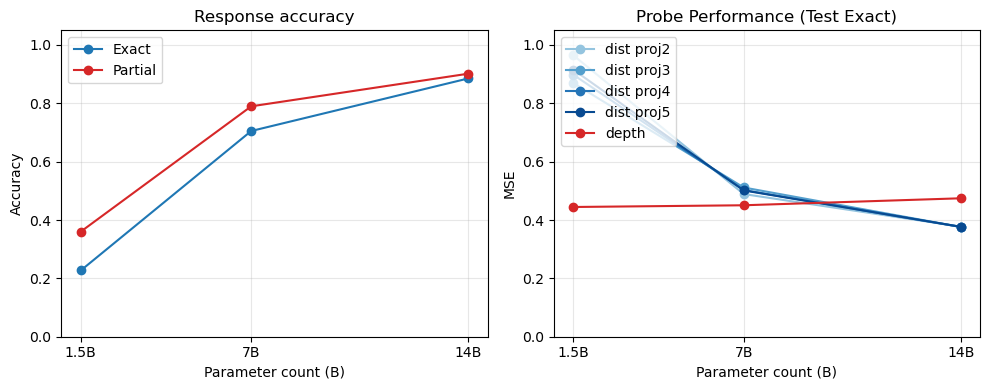

In [50]:
if metrics_df.empty:
    print('No artifacts found; missing:', missing)
else:
    # Accuracy panel data (once per model)
    acc_df = metrics_df.drop_duplicates('params_b').sort_values('params_b')
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
    axes[0].plot(acc_df['params_b'], acc_df['exact'], 'o-', color="#1f77b4", label='Exact')
    axes[0].plot(acc_df['params_b'], acc_df['partial'], 'o-', color="#d62728", label='Partial')
    axes[0].set_xlabel('Parameter count (B)')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Response accuracy')
    axes[0].set_ylim(0, 1.05)
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    axes[0].set_xticks(acc_df['params_b'])
    axes[0].set_xticklabels(acc_df['size'])

    # Probe MSE across proj dims (distance blue, depth red)
    proj_dims_sorted = sorted(metrics_df['proj_dim'].unique())
    dist_colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(proj_dims_sorted)))
    dist_lines = []
    for dist_color, proj_dim in zip(dist_colors, proj_dims_sorted):
        subset = metrics_df[metrics_df['proj_dim'] == proj_dim].sort_values('params_b')
        dist_line = axes[1].plot(subset['params_b'], subset['dist_mse'], 'o-', color=dist_color, label=f'dist proj{proj_dim}')[0]
        dist_lines.append(dist_line)
    
    # Depth line (single line, aggregated across proj_dims; depth is independent of proj_dim but depends on PCA preprocessing)
    depth_df = metrics_df.drop_duplicates('params_b').sort_values('params_b')
    depth_line = axes[1].plot(depth_df['params_b'], depth_df['depth_mse'], 'o-', color='#d62728', label='depth')[0]
    axes[1].set_ylim(0, 1.05)
    axes[1].set_xlabel('Parameter count (B)')
    axes[1].set_ylabel('MSE')
    axes[1].set_title('Probe Performance (Test Exact)')
    axes[1].grid(alpha=0.3)

    axes[1].set_xticks(acc_df['params_b'])
    axes[1].set_xticklabels(acc_df['size'])
    legend_handles = dist_lines + [depth_line]
    legend_labels = [h.get_label() for h in legend_handles]
    axes[1].legend(legend_handles, legend_labels, loc='upper left')
    plt.tight_layout()

    size  params_b  proj_dim  exact   partial  dist_corr  dist_layer  \
0   1.5B       1.5         2  0.227  0.360071   0.316505          21   
1   1.5B       1.5         3  0.227  0.360071   0.337354          21   
2   1.5B       1.5         4  0.227  0.360071   0.325554          21   
3   1.5B       1.5         5  0.227  0.360071   0.304594          21   
4     7B       7.0         2  0.705  0.789608   0.684243          21   
5     7B       7.0         3  0.705  0.789608   0.672605          21   
6     7B       7.0         4  0.705  0.789608   0.678007          21   
7     7B       7.0         5  0.705  0.789608   0.678632          21   
8    14B      14.0         2  0.885  0.901323   0.769202          31   
9    14B      14.0         3  0.885  0.901323   0.769442          31   
10   14B      14.0         4  0.885  0.901323   0.772036          31   
11   14B      14.0         5  0.885  0.901323   0.771890          31   

    depth_corr  depth_layer  \
0     0.468584           21   
1

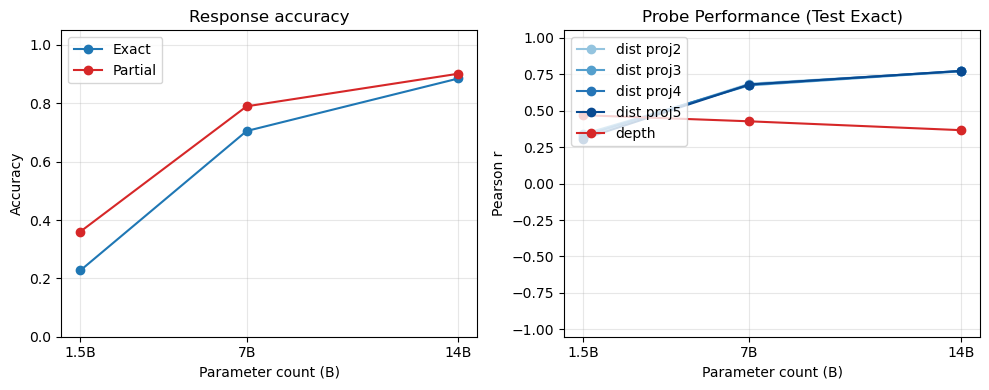

In [51]:
# Pearson-based version of the visualization
pearson_rows = []
pearson_missing = []
for label, model_id in MODEL_SIZES.items():
    responses_fp = path_utils.responses_path(DATASET_TAG, model_id)
    reps = load_responses(responses_fp) if responses_fp.exists() else []
    exact = float(np.mean([rec.exact_match for rec in reps])) if reps else float('nan')
    partial = float(np.mean([rec.partial_score for rec in reps])) if reps else float('nan')
    best_layer = BEST_LAYERS[label]
    for proj_dim in PROJ_DIMS:
        probe_fp = _probe_path(DATASET_TAG, model_id, proj_dim)
        if not responses_fp.exists() or not probe_fp.exists():
            pearson_missing.append(f"{label} proj{proj_dim}: responses={responses_fp.exists()} probe={probe_fp.exists()}")
            continue
        results, meta = _load_probe_metrics(probe_fp)
        layer_results = results.get(best_layer, {})
        dist_corr = layer_results.get('dist_corr_test_exact')
        dist_corr = float(dist_corr) if dist_corr is not None else float('nan')

        depth_block = layer_results.get('depth', {})
        if isinstance(depth_block, dict):
            depth_corr = depth_block.get('test_exact', {}).get('pearson')
            depth_corr = float(depth_corr) if depth_corr is not None else float('nan')
        else:
            depth_corr = float('nan')

        pearson_rows.append({
            'size': label,
            'params_b': float(label.replace('B', '')),
            'proj_dim': proj_dim,
            'exact': exact,
            'partial': partial,
            'dist_corr': dist_corr,
            'dist_layer': best_layer,
            'depth_corr': depth_corr,
            'depth_layer': best_layer,
            'responses_path': str(responses_fp),
            'probe_path': str(probe_fp),
            'pca_components': int(meta.get('pca_components', -1)),
        })
pearson_df = pd.DataFrame(pearson_rows).sort_values(['params_b', 'proj_dim'])
print(pearson_df)
if pearson_missing:
    print('Missing artifacts:')
    for msg in pearson_missing:
        print(' -', msg)

if pearson_df.empty:
    print('No artifacts found; missing:', pearson_missing)
else:
    acc_df = pearson_df.drop_duplicates('params_b').sort_values('params_b')
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
    axes[0].plot(acc_df['params_b'], acc_df['exact'], 'o-', color='#1f77b4', label='Exact')
    axes[0].plot(acc_df['params_b'], acc_df['partial'], 'o-', color='#d62728', label='Partial')
    axes[0].set_xlabel('Parameter count (B)')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Response accuracy')
    axes[0].set_ylim(0, 1.05)
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    axes[0].set_xticks(acc_df['params_b'])
    axes[0].set_xticklabels(acc_df['size'])

    proj_dims_sorted = sorted(pearson_df['proj_dim'].unique())
    dist_colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(proj_dims_sorted)))
    dist_lines = []
    for dist_color, proj_dim in zip(dist_colors, proj_dims_sorted):
        subset = pearson_df[pearson_df['proj_dim'] == proj_dim].sort_values('params_b')
        dist_line = axes[1].plot(subset['params_b'], subset['dist_corr'], 'o-', color=dist_color, label=f'dist proj{proj_dim}')[0]
        dist_lines.append(dist_line)

    depth_df = pearson_df.drop_duplicates('params_b').sort_values('params_b')
    depth_line = axes[1].plot(depth_df['params_b'], depth_df['depth_corr'], 'o-', color='#d62728', label='depth')[0]
    axes[1].set_ylim(-1.05, 1.05)
    axes[1].set_xlabel('Parameter count (B)')
    axes[1].set_ylabel('Pearson r')
    axes[1].set_title('Probe Performance (Test Exact)')
    axes[1].grid(alpha=0.3)

    axes[1].set_xticks(acc_df['params_b'])
    axes[1].set_xticklabels(acc_df['size'])
    legend_handles = dist_lines + [depth_line]
    legend_labels = [h.get_label() for h in legend_handles]
    axes[1].legend(legend_handles, legend_labels, loc='upper left')
    plt.tight_layout()

In [52]:
# Per-example distance MSE vs partial accuracy (combined across models)
from pathlib import Path

from cutter.scripts.evaluate_probe import load_responses, load_embedding_cache, build_layer_from_cache
from cutter.utils.shared.basic import split_balanced, split_exact_only
from cutter.utils.tree.probing import pairwise_distance, transform_probe_space, fit_distance_probe
from cutter.utils.tree.trees import DistanceProbeConfig, pairwise_tree_distances

PER_EXAMPLE_PROJ_DIM = 5
PER_EXAMPLE_BINS = 5


def _pca_transform(features: np.ndarray, res: dict) -> np.ndarray:
    pca = res.get("pca") if isinstance(res, dict) else None
    if not pca:
        return features
    components = np.asarray(pca.get("components", []), dtype=np.float32)
    mean = np.asarray(pca.get("mean", 0.0), dtype=np.float32)
    if components.size == 0:
        return features
    if features.shape[1] == components.shape[0]:
        return features
    return (features - mean) @ components.T


def _resolve_probe_projection(res: dict) -> np.ndarray:
    if isinstance(res, dict) and isinstance(res.get("distance"), dict) and res["distance"].get("projection") is not None:
        return res["distance"]["projection"]
    if isinstance(res, dict) and res.get("projection") is not None:
        return res["projection"]
    raise ValueError("No projection found in results for the requested layer.")


def _resolve_distance_probe(layer: int, res: dict, data: dict, meta: dict):
    """Return (projection, info) for a layer, preferring saved probe weights."""
    res = res or {}
    if isinstance(res, dict):
        try:
            proj = _resolve_probe_projection(res)
        except Exception:
            proj = None
        if proj is not None:
            info = {
                "geometry": res.get("geometry", meta.get("fit_geometry", "euclidean")),
                "center": res.get("center"),
                "curvature": res.get("curvature"),
                "normalized_tree": res.get("normalized_tree", meta.get("normalize_tree", False)),
            }
            return proj, info
    # Refit using stored encodings if projection is missing
    X = data.get("X") if isinstance(data, dict) else None
    dist = data.get("dist") if isinstance(data, dict) else None
    train_idx = data.get("train_idx") if isinstance(data, dict) else None
    if X is None or dist is None or train_idx is None:
        raise RuntimeError("Encodings missing X/dist/train_idx; cannot recover projection")
    train_idx = np.asarray(train_idx, dtype=int)
    X_train = _pca_transform(np.asarray(X)[train_idx], res)
    dist_train = np.asarray(dist)[np.ix_(train_idx, train_idx)]
    cfg = DistanceProbeConfig(
        proj_dim=int(meta.get("proj_dim", 16)),
        lr=float(meta.get("lr", 1e-2)),
        epochs=int(meta.get("epochs", 1000)),
        fit_geometry=meta.get("fit_geometry", "euclidean"),
        device=meta.get("device", "cpu"),
        normalized_tree=meta.get("normalize_tree", False),
        verbose=False,
    )
    refit = fit_distance_probe(X_train, dist_train, cfg)
    proj = refit.projection
    info = {
        "geometry": cfg.fit_geometry,
        "center": refit.center,
        "curvature": refit.curvature,
        "normalized_tree": cfg.normalized_tree,
    }
    return proj, info


def _resolve_artifact_path(path_value: str | None) -> Path | None:
    if not path_value:
        return None
    path = Path(path_value)
    if not path.is_absolute():
        path = PROJECT_ROOT / path
    return path


def _rebuild_layer_data(meta: Dict[str, Any], target_layer: int) -> Dict[str, Any] | None:
    embeddings_path = _resolve_artifact_path(meta.get("embeddings_path"))
    responses_path = _resolve_artifact_path(meta.get("responses_path"))
    if embeddings_path is None or responses_path is None:
        return None
    if not embeddings_path.exists() or not responses_path.exists():
        return None
    responses = load_responses(responses_path)
    seed = int(meta.get("seed", 42))
    train_split = float(meta.get("train_split", 0.8))
    split_type = meta.get("split_type", "balanced")
    if split_type == "exact-only":
        train_records, test_records = split_exact_only(responses, train_split, seed, exact_attr="exact_match")
    else:
        train_records, test_records = split_balanced(responses, train_split, seed, exact_attr="exact_match")
    cache = load_embedding_cache(embeddings_path)
    return build_layer_from_cache(train_records, test_records, target_layer, cache)


def per_example_distance_scores(
    encodings: Dict[int, Any], results: Dict[int, Any], meta: Dict[str, Any], target_layer: int, model_label: str
) -> pd.DataFrame:
    rows: List[Dict[str, Any]] = []
    data = (encodings or {}).get(target_layer, {})
    if not isinstance(data, dict) or data.get("X") is None:
        rebuilt = _rebuild_layer_data(meta, target_layer)
        if rebuilt:
            data = rebuilt
    res = results.get(target_layer, {}) if isinstance(results, dict) else {}
    X = data.get("X") if isinstance(data, dict) else None
    node_ids = data.get("node_ids") if isinstance(data, dict) else None
    example_ids = data.get("example_ids") if isinstance(data, dict) else None
    example_acc = data.get("example_accuracy") if isinstance(data, dict) else None
    train_idx = set(np.asarray(data.get("train_idx", []), dtype=int).tolist()) if isinstance(data, dict) else set()
    if X is None or node_ids is None or example_ids is None:
        return pd.DataFrame(rows)
    B, info = _resolve_distance_probe(target_layer, res, data, meta)
    geometry = info.get("geometry", meta.get("fit_geometry", "euclidean"))
    center = info.get("center")
    curvature = info.get("curvature")
    X_feat = _pca_transform(np.asarray(X), res)
    Z = X_feat @ np.asarray(B)
    if geometry == "hyperbolic":
        Z = transform_probe_space(Z, info)
    dist_pred = pairwise_distance(Z, geometry, center=center, curvature=curvature)
    example_ids_arr = np.asarray(example_ids)
    node_ids_arr = np.asarray(node_ids)
    for ex_id in np.unique(example_ids_arr):
        mask = example_ids_arr == ex_id
        idxs = np.where(mask)[0]
        if idxs.size < 2:
            continue
        split = "train" if any(idx in train_idx for idx in idxs) else "test"
        acc = float(np.asarray(example_acc)[mask][0]) if example_acc is not None else np.nan
        tri = np.triu_indices(idxs.size, k=1)
        true_sub = pairwise_tree_distances(node_ids_arr[idxs])[tri]
        pred_sub = dist_pred[np.ix_(idxs, idxs)][tri]
        mse = np.mean((true_sub - pred_sub) ** 2) if true_sub.size > 1 else np.nan
        rows.append(
            {
                "model": model_label,
                "example_id": int(ex_id),
                "split": split,
                "model_accuracy": acc,
                "dist_mse": mse,
            }
        )
    return pd.DataFrame(rows)


def binned_avg_std_pearson(x: np.ndarray, y: np.ndarray, nbins: int = 10, xlim=(0, 1)):
    """Bin x, aggregate y by mean/std per bin. Returns bin centers, mean, std, counts (NaN bins filtered out)."""
    bins = np.linspace(xlim[0], xlim[1], nbins + 1)
    digitized = np.digitize(x, bins) - 1
    digitized = np.clip(digitized, 0, nbins - 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    y_mean = np.array([y[digitized == i].mean() if np.any(digitized == i) else np.nan for i in range(nbins)])
    y_std = np.array([y[digitized == i].std() if np.any(digitized == i) else np.nan for i in range(nbins)])
    counts = np.array([np.sum(digitized == i) for i in range(nbins)])
    valid = ~np.isnan(y_mean)
    return bin_centers[valid], y_mean[valid], y_std[valid], counts[valid]


per_example_frames = []
per_example_missing: List[str] = []
for label, model_id in MODEL_SIZES.items():
    probe_fp = _probe_path(DATASET_TAG, model_id, PER_EXAMPLE_PROJ_DIM)
    if not probe_fp.exists():
        per_example_missing.append(f"{label} proj{PER_EXAMPLE_PROJ_DIM}: probe={probe_fp.exists()}")
        continue
    artifact = np.load(probe_fp, allow_pickle=True)
    meta = artifact["meta"].item()
    encodings = artifact["encodings"].item()
    results = artifact["results"].item()
    df = per_example_distance_scores(encodings, results, meta, BEST_LAYERS[label], label)
    if not df.empty:
        per_example_frames.append(df)

per_example_df = pd.concat(per_example_frames, ignore_index=True) if per_example_frames else pd.DataFrame()
if per_example_missing:
    print("Missing per-example artifacts:")
    for msg in per_example_missing:
        print(" -", msg)

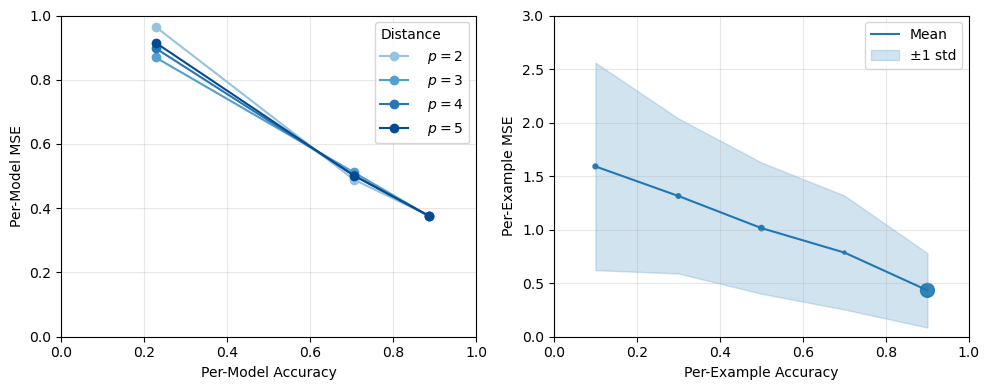

In [54]:
if metrics_df.empty:
    print('No artifacts found; missing:', missing)
else:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Left: distance probes across projection dims
    proj_dims_sorted = sorted(metrics_df['proj_dim'].unique())
    dist_colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(proj_dims_sorted)))
    distance_handles = []
    for dist_color, proj_dim in zip(dist_colors, proj_dims_sorted):
        subset = metrics_df[metrics_df['proj_dim'] == proj_dim].sort_values('params_b')
        axes[0].plot(subset['exact'], subset['dist_mse'], marker='o', linestyle='-', color=dist_color)
        distance_handles.append(
            plt.Line2D([0], [0], color=dist_color, marker='o', linestyle='-', label=f'  $p={proj_dim}$')
        )

    axes[0].set_xlabel('Per-Model Accuracy')
    axes[0].set_ylabel('Per-Model MSE')
    axes[0].set_xlim(0, 1)
    axes[0].set_ylim(0, 1)

    leg = axes[0].legend(handles=distance_handles, title='Distance', loc='upper right')
    leg.get_title().set_ha('left')
    leg._legend_box.align = 'left'
    axes[0].grid(alpha=0.3)

    # Right: per-example distance MSE vs partial accuracy (combined)
    if per_example_df.empty:
        print('No per-example data available for combined plot.')
        axes[1].set_xlabel('Task Accuracy (partial)')
        axes[1].set_ylabel('Per-Example MSE')
        axes[1].set_xlim(0, 1)
        axes[1].set_ylim(0, 1)
        axes[1].grid(alpha=0.3)
        axes[1].text(0.5, 0.5, 'No per-example data', ha='center', va='center')
    else:
        test_df = per_example_df[per_example_df['split'] == 'test']
        x_vals = test_df['model_accuracy'].values
        y_vals = test_df['dist_mse'].values
        valid = ~np.isnan(x_vals) & ~np.isnan(y_vals)
        bin_centers, y_mean, y_std, counts = binned_avg_std_pearson(
            x_vals[valid],
            y_vals[valid],
            nbins=PER_EXAMPLE_BINS,
        )
        if counts.size:
            sizes = 100 * (counts / counts.max())
        else:
            sizes = 100
        axes[1].plot(bin_centers, y_mean, '-', color='#1f77b4', label='Mean')
        axes[1].scatter(bin_centers, y_mean, s=sizes, color='#1f77b4', alpha=0.9)
        axes[1].fill_between(
            bin_centers,
            y_mean - y_std,
            y_mean + y_std,
            color='#1f77b4',
            alpha=0.2,
            label='±1 std',
        )
        axes[1].set_xlabel('Per-Example Accuracy')
        axes[1].set_ylabel('Per-Example MSE')
        axes[1].set_xlim(0, 1)
        axes[1].set_ylim(0, 3)
        axes[1].grid(alpha=0.3)
        axes[1].legend()

    plt.tight_layout()
    plt.savefig('../figures/paper/depth1-2_n1000_steps1-2/cross-model-accuracy-vs-mse.png', dpi=300)